# Camera Calibration using Zhang's Method

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import scipy.linalg

## Load images to grayscale images

In [3]:
images_gray = []

dir_calib_name = "../data/calib03"
filenames = os.listdir(dir_calib_name)
for fname in filenames:
    fname_path = os.path.join(dir_calib_name, fname)
    print(fname)
    images_gray.append(cv.imread(fname_path, cv.IMREAD_GRAYSCALE))

print("Number of images: {}".format(len(images_gray)))

left01.jpg
left02.jpg
left03.jpg
left04.jpg
left05.jpg
left06.jpg
left07.jpg
left08.jpg
left09.jpg
left11.jpg
left12.jpg
left13.jpg
left14.jpg
Number of images: 13


## Find corners in chessboard images

In [4]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objp[:,:2] *= 21.5 # 21.5 mm is the size of each square in the chessboard
objp[:,2] = 1 # z coordinate is 0 since the chessboard is planar

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

corners = []
for img in tqdm(images_gray):
    #Find chessboard corners
    ret, corners = cv.findChessboardCorners(img, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(img, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

objpoints = np.array(objpoints)
imgpoints = np.array(imgpoints)

print("Object points shape: {}".format(objpoints.shape))
print("Image points shape: {}".format(imgpoints.shape))
print("Is found corners from all images? {}".format(imgpoints.shape[0] == len(images_gray)))

  0%|          | 0/13 [00:00<?, ?it/s]

Object points shape: (13, 54, 3)
Image points shape: (13, 54, 1, 2)
Is found corners from all images? True


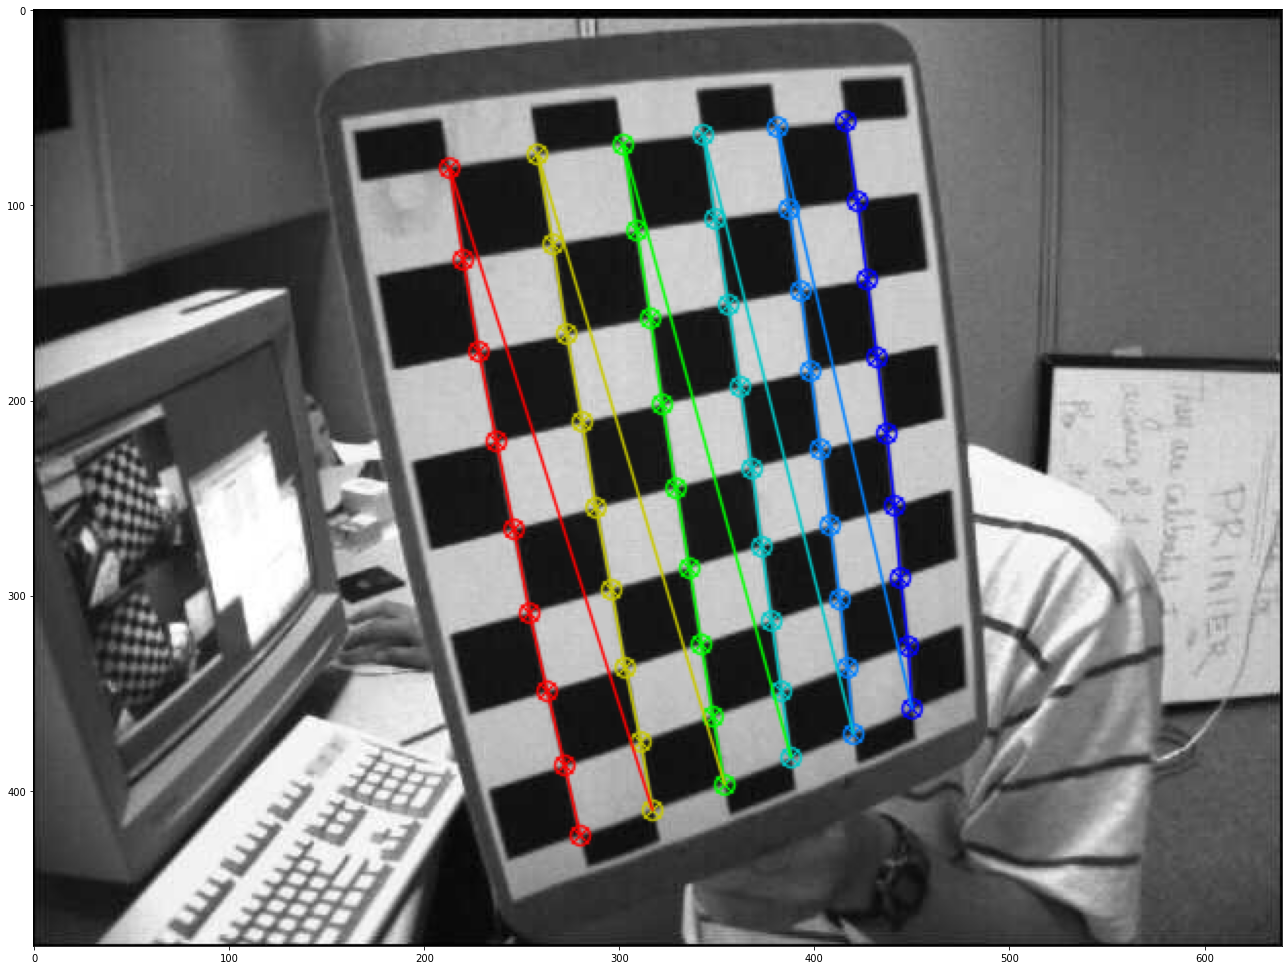

In [5]:
# Draw and display the corners
img_w_corners = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
cv.drawChessboardCorners(img_w_corners, (9,6), corners2, ret)
fig, ax = plt.subplots(figsize=(18, 16))
ax.imshow(img_w_corners, cmap='gray')
plt.tight_layout()

# Find homography of given images

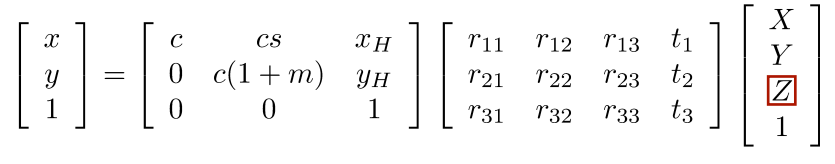

Since the calibration board is a flat surface, the Z coordinate of each point on the checkboard is equal to zero. 
Therefore the equation on the above can be expressed as below.

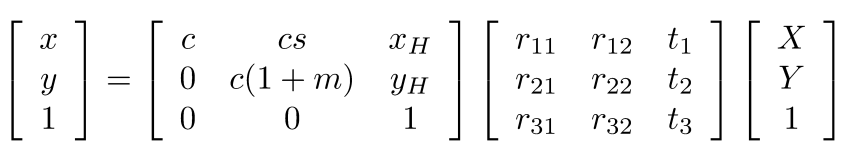

Now one point observed on the checkerboard generates such an equation.
We have 13(number of image) and 54(9x6 calibration pattern) points pair, therefore we have total of 702(13 * 54) equation of the above equation.

**How can we solve this?**

We can express equation as DLT-Like Estimation


We can estimate H via SVD.
We will have 13 homography matrix. 

In [6]:
H = []
# create matrix for DLT-like estimation
for i in range(len(objpoints)):
    M = []
    for j in range(len(objpoints[i])):
        x, y = imgpoints[i][j][0]
        X, Y, Z = objpoints[i][j]
        M.append([X, Y, 1, 0, 0, 0, -x*X, -x*Y, -x])
        M.append([0, 0, 0, X, Y, 1, -y*X, -y*Y, -y])
    M = np.array(M)

    # Find optimal p with SVD
    U, S, V = np.linalg.svd(M)
    p = V[-1]   
    print("Residual: {}".format(np.linalg.norm(np.dot(M, p))))
    h = p.reshape(3, 3)
    h /= h[2,2]
    H.append(h)

Residual: 0.023444607842761273
Residual: 0.020656310511055785
Residual: 0.043223282640527064
Residual: 0.041831700290382336
Residual: 0.023245608593335503
Residual: 0.017527758555755914
Residual: 0.016878030203024915
Residual: 0.02033085973546518
Residual: 0.03312181561285635
Residual: 0.01939635840693591
Residual: 0.02317981778312342
Residual: 0.017334773384421288
Residual: 0.02122841450514683


In [7]:
H[0]

array([[ 1.25432514e+00,  9.67615896e-02,  2.43843361e+02],
       [-9.46434695e-02,  1.56868743e+00,  9.19375309e+01],
       [-6.29211988e-04,  2.40276354e-04,  1.00000000e+00]])

# Decompose the homography matrix H with K(calibration matrix) and R, T(rotation and translation)

not applicable QR composition -> use SVD

1. Exploit constraints about K, r1, r2
    K <- invertible matrix -> r1 = K^-1h1 -> r2 = K^-1h2
    r_1, r_2 are rotation for each direction -> form a orthonomal basis -> r_1^Tr_2 =0 ||r_1||=||r_2||=1

$h_1^TK^{-T}K^{-1}h_2 = 0$

$h_1^T K^{-T} K^{-1} h_1 = h_2^T K^{-T} K^{-1} h_2 \leftrightarrow h_1^T K^{-T} K^{-1} h_1 - h_2^T K^{-T} K^{-1} h_2 = 0$

2. Define a positive semidefinite matrix matrix $B =K^{-T}K^{-1}$ 

$h_1^TBh_2 = 0$

$h_1^T B h_1 = h_2^T B h_2 \leftrightarrow h_1^T B h_1 - h_2^T B h_2 = 0$

3. This B can be computed by solving another homogeneous linear system

$chol(B) = AA^T \Leftrightarrow A = K^{-T} $

If we know B, then we can compute K

4. Decompose matrix B

In [8]:
## create matrix V for calculate B
def get_Vt(H, i, j):
    v_t = [H[0,i]*H[0,j], 
           H[0,i]*H[1,j]+H[1,i]*H[0,j],
           H[2,i]*H[0,j]+H[0,i]*H[2,j],
           H[1,i]*H[1,j],
           H[2,i]*H[1,j]+H[1,i]*H[2,j],
           H[2,i]*H[2,j]]
    return v_t

## first build up matrix V for all images
V = []
for i in tqdm(range(len(objpoints))):
    Vt_12 = get_Vt(H[i], 0, 1)
    Vt_11 = get_Vt(H[i], 0, 0)
    Vt_22 = get_Vt(H[i], 1, 1)
    V.append(np.array(Vt_12))
    V.append(np.array(Vt_11) - np.array(Vt_22))

# Find B with SVD
V = np.array(V)
print(V.shape)
U, S, V = np.linalg.svd(V)
b = V[-1]
print("Residual: {}".format(np.linalg.norm(np.dot(V, b))))
B = np.array([[b[0], b[1], b[2]],
                [b[1], b[3], b[4]],
                [b[2], b[4], b[5]]])
print("B: {}, ||B||: {}".format(B, np.linalg.norm(B)))


#find K with Cholesky decomposition
A = np.array(scipy.linalg.cholesky(B, lower=True))

print("A:{}".format(A))

K = np.linalg.inv(np.transpose(A))
K /= K[2,2]
print("K: {}".format(K))
A_inv = np.linalg.inv(K)

# get rotation and translation for each image
print("Get Rotation and Translation vector for each image")
R = []
T = []
for i in tqdm(range(len(objpoints))):
    h1 = H[i][:,0]
    h2 = H[i][:,1]
    h3 = H[i][:,2]
    lam = 1/np.linalg.norm(np.dot(A_inv, h1), 2)
    r1 = lam * np.dot(A_inv, h1)
    r2 = lam * np.dot(A_inv, h2)
    t = lam * np.dot(A_inv, h3)
    r = np.array([r1, r2]).transpose()
    R.append(r)
    T.append(t)
    print(K, r, t)
    

  0%|          | 0/13 [00:00<?, ?it/s]

(26, 6)
Residual: 0.9999999999999999
B: [[ 2.10760433e-06  7.60152123e-09 -7.47299851e-04]
 [ 7.60152123e-09  2.09694572e-06 -4.94149436e-04]
 [-7.47299851e-04 -4.94149436e-04  9.99999599e-01]], ||B||: 1.000000401320286
A:[[ 1.45175905e-03  0.00000000e+00  0.00000000e+00]
 [ 5.23607636e-06  1.44807400e-03  0.00000000e+00]
 [-5.14754741e-01 -3.39384687e-01  7.87302477e-01]]
K: [[542.30933085  -1.96093091 353.72782023]
 [  0.         543.68939514 234.36971264]
 [  0.           0.           1.        ]]
Get Rotation and Translation vector for each image


  0%|          | 0/13 [00:00<?, ?it/s]

[[542.30933085  -1.96093091 353.72782023]
 [  0.         543.68939514 234.36971264]
 [  0.           0.           1.        ]] [[ 0.97375092  0.01135462]
 [ 0.0347357   0.99448367]
 [-0.22495017  0.08590143]] [-72.77867417 -93.6583713  357.51094049]
[[542.30933085  -1.96093091 353.72782023]
 [  0.         543.68939514 234.36971264]
 [  0.           0.           1.        ]] [[ 0.10905471  0.97366066]
 [-0.75323067  0.19868463]
 [-0.64865294 -0.04903851]] [-56.42559742  71.58300022 309.39473246]
[[542.30933085  -1.96093091 353.72782023]
 [  0.         543.68939514 234.36971264]
 [  0.           0.           1.        ]] [[ 0.93478949 -0.36140207]
 [ 0.31739426  0.91200402]
 [-0.15946628 -0.28830346]] [-40.41413962 -86.66165665 284.28379637]
[[542.30933085  -1.96093091 353.72782023]
 [  0.         543.68939514 234.36971264]
 [  0.           0.           1.        ]] [[ 0.97245579 -0.00361371]
 [-0.01524706  0.9922742 ]
 [-0.23258819 -0.13061582]] [-90.77108654 -57.24231031 294.39167902]


We found a closed-form solution of K with pinhole camera model,
now expand for more realistic camera model with radial distortion
since the model with radial distortion is non-linear model, 
we now optimize with Levenverg-Marquardt(LM) method

Now optimize with maximize likelihood estimation with LM method

In [140]:
# define reprojection error for each image
# construct camera matrix A from x0
def get_A_from_x0(x0):
    alpha = x0[0]
    gamma = x0[1]
    beta = x0[2]
    u0 = x0[3]
    v0 = x0[4]
    
    Ae = np.array([[alpha, gamma, u0],
                    [0, beta, v0],
                    [0, 0, 1]])
    return Ae

def reproject_points(idx_img, objpoints, imgpoints, x0, R, T):
    k = get_A_from_x0(x0)
    alpha, gamma, beta, u0, v0, k1, k2 = x0
    Rt = np.concatenate([R[idx_img], np.expand_dims(T[idx_img],axis=0).transpose()],axis=1)
    imgpoints_projected = []
    # for idx_corner in range(0, objpoints.shape[1]):
    #     imgpoints_proj = np.dot(np.dot(k, Rt), np.transpose(objpoints[idx_img, idx_corner]))
    #     imgpoints_proj /= imgpoints_proj[2]
    #     u = imgpoints_proj[0]
    #     v = imgpoints_proj[1]
    #     x = objpoints[idx_img, idx_corner, 0]
    #     y = objpoints[idx_img, idx_corner, 0]
    #     r2 = x**2 + y**2
    #     radial_distortion = k1*r2 + k2*r2**2
    #     imgpoints_proj[0] += (x-u0) * radial_distortion
    #     imgpoints_proj[1] += (y-v0) * radial_distortion
    #     imgpoints_projected.append(imgpoints_proj[:2])
    #     print(imgpoints_proj[:2])
    for idx_corner in range(0, objpoints.shape[1]):
        imgpoints_proj = np.dot(np.dot(k, Rt), np.transpose(objpoints[idx_img, idx_corner]))
        imgpoints_plane_proj = np.dot(Rt, np.transpose(objpoints[idx_img, idx_corner]))
        imgpoints_proj /= imgpoints_proj[2]
        u = imgpoints_proj[0]
        v = imgpoints_proj[1]
        imgpoints_plane_proj /= imgpoints_plane_proj[2]
        x = imgpoints_plane_proj[0]
        y = imgpoints_plane_proj[1]
        r2 = x**2 + y**2
        radial_distortion = k1*r2 + k2*r2**2
        x_d = u + (u-u0) * radial_distortion
        y_d = v + (v-v0) * radial_distortion
        imgpoints_projected.append([x_d, y_d])
    imgpoints_projected = np.array(imgpoints_projected)
    e = np.linalg.norm((imgpoints[idx_img] - imgpoints_projected), ord=2) / objpoints.shape[1]
    print("Reprojection Error: {}".format(e))
    print(imgpoints_projected.shape)
    
    plt.imshow(images_gray[idx_img], cmap='gray')
    plt.plot(imgpoints_projected[:,0], imgpoints_projected[:,1], 'ro')

def draw_imgpoints(idx_img):
    plt.imshow(images_gray[idx_img], cmap='gray')
    plt.plot(imgpoints[idx_img,:,0,0], imgpoints[idx_img,:,0,1], 'ro')


Reprojection Error: 0.095816394722552
(54, 2)


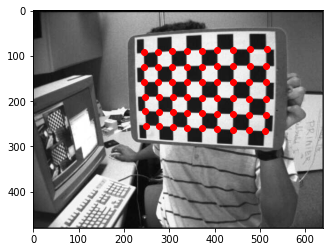

In [141]:
alpha = K[0,0]
gamma = K[0,1]
beta = K[1,1] 
u0 = K[0,2]
v0 = K[1,2]
k1 = 0
k2 = 0
x0=[alpha, gamma, beta, u0, v0, k1, k2]
reproject_points(0, objpoints, imgpoints[:,:,0,:], x0, R, T)

In [187]:
def get_init_distortion(imgpoints, objpoints, k, r_loc, t_loc):
    D = []
    d = []
    for idx_img in range(0, objpoints.shape[0]):
        Rt = np.concatenate([r_loc[idx_img,:,:], np.expand_dims(t_loc[idx_img,:],axis=0).transpose()],axis=1)
        imgpoints_projected = []
        distortion_projected = []
        
        for idx_corner in range(0, objpoints.shape[1]):
            imgpoints_proj = np.dot(np.dot(k, Rt), np.transpose(objpoints[idx_img, idx_corner]))
            imgpoints_proj /= imgpoints_proj[2]
            u = imgpoints_proj[0]
            v = imgpoints_proj[1]
            imgpoints_plane_proj = np.dot(Rt, np.transpose(objpoints[idx_img, idx_corner]))
            imgpoints_plane_proj /= imgpoints_plane_proj[2]
            x = imgpoints_plane_proj[0]
            y = imgpoints_plane_proj[1]
            r2 = x**2 + y**2
            D.append([(u-u0) * r2, (u-u0) * r2**2])
            D.append([(v-v0) * r2, (v-v0) * r2**2])
            d.append((imgpoints[idx_img,idx_corner,0]-u))
            d.append((imgpoints[idx_img,idx_corner,1]-v))
    D = np.array(D)
    d = np.array(d)
    U, S, Vh=np.linalg.svd(D, full_matrices=False)
    temp_S = np.array([[S[0], 0],
                       [0, S[1]]])
    temp_res = np.dot(Vh.transpose(), np.linalg.inv(temp_S))
    temp_res_res = np.dot(temp_res, U.transpose())
    k = np.dot(temp_res_res, d)
    return k

In [190]:
R, T = np.array(R), np.array(T)
k1, k2 = get_init_distortion(imgpoints[:,:,0,:], objpoints, K, R, T)
print("k1: {}, k2: {}".format(k1, k2))

[ 0.05180252 -0.54901027]


In [194]:
# optimize M for entire images with radial distortion via Levenberg-Marquardt algorithm
import scipy.optimize
alpha = K[0,0]
gamma = K[0,1]
beta = K[1,1] 
u0 = K[0,2]
v0 = K[1,2]
R_new, T_new = np.array(R), np.array(T)

x0 = [alpha, gamma, beta, u0, v0, k1, k2]
print("alpha: {}, gamma: {}, beta: {}, u0: {}, v0: {}, k1: {}, k2: {}".format(alpha, gamma, beta, u0, v0, k1, k2))
R_flat = list(np.reshape(R_new, -1))
T_flat = list(np.reshape(T_new, -1))
x0.extend(R_flat)
x0.extend(T_flat)

def loss_func(x0, imgpoints, objpoints):
    r_loc = np.array(x0[7:7+len(imgpoints)*3*2], dtype=np.float32).reshape(len(imgpoints), 3, 2)
    t_loc = np.array(x0[7+len(imgpoints)*3*2:], dtype=np.float32).reshape(len(imgpoints), 3)
    k = get_A_from_x0(x0)
    alpha, gamma, beta, u0, v0, k1, k2 = x0[:7]
    error_mat = np.array([]).reshape(0,2)
    for idx_img in range(0, objpoints.shape[0]):
        Rt = np.concatenate([r_loc[idx_img,:,:], np.expand_dims(t_loc[idx_img,:],axis=0).transpose()],axis=1)
        imgpoints_projected = []
        for idx_corner in range(0, objpoints.shape[1]):
            imgpoints_proj = np.dot(np.dot(k, Rt), np.transpose(objpoints[idx_img, idx_corner]))
            imgpoints_plane_proj = np.dot(Rt, np.transpose(objpoints[idx_img, idx_corner]))
            imgpoints_proj /= imgpoints_proj[2]
            u = imgpoints_proj[0]
            v = imgpoints_proj[1]
            imgpoints_plane_proj /= imgpoints_plane_proj[2]
            x = imgpoints_plane_proj[0]
            y = imgpoints_plane_proj[1]
            r2 = x**2 + y**2
            radial_distortion = k1*r2 + k2*r2**2
            x_d = u + (u-u0) * radial_distortion
            y_d = v + (v-v0) * radial_distortion
            imgpoints_projected.append([x_d, y_d])
        e = imgpoints[idx_img] - np.array(imgpoints_projected)
        error_mat = np.vstack([error_mat, e])
    return error_mat.flatten()

res = scipy.optimize.least_squares(fun=loss_func, 
                                   method="lm", 
                                   x0 = x0,
                                   args=(imgpoints[:,:,0,:], objpoints),
                                   verbose=2)

alpha: 542.3093308484763, gamma: -1.9609309129325474, beta: 543.6893951368503, u0: 353.7278202305808, v0: 234.36971263633455, k1: 0.051802515328400044, k2: -0.5490102725885996
`ftol` termination condition is satisfied.
Function evaluations 626, initial cost 5.0391e+02, final cost 3.4616e+02, first-order optimality 4.20e+03.


In [195]:
alpha   = res.x[0]
gamma   = res.x[1]
beta    = res.x[2]
u0      = res.x[3]
v0      = res.x[4]
k1      = res.x[5]
k2      = res.x[6]
R_new = np.array(res.x[7:7+len(imgpoints)*3*2]).reshape(len(imgpoints), 3, 2)
T_new = np.array(res.x[7+len(imgpoints)*3*2:]).reshape(len(imgpoints), 3)
print("alpha: {}, gamma: {}, beta: {}, u0: {}, v0: {}, k1: {}, k2: {}".format(alpha, gamma, beta, u0, v0, k1, k2))

alpha: 552.183227466373, gamma: -1.9190405345876167, beta: 553.051184164343, u0: 353.79166507652786, v0: 234.42398298619386, k1: -0.25765160026643047, k2: 0.5894424981784191


# Reproject Points in the Image

Reprojection Error: 0.06973190925849497
(54, 2)


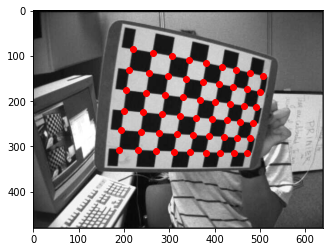

In [144]:
reproject_points(8, objpoints, imgpoints[:,:,0,:], res.x[:7], R_new, T_new)

In [153]:
img_idx = 1
K_new = get_A_from_x0(res.x)
h = images_gray[0].shape[0]
w = images_gray[0].shape[1]
print(K_new, k1, k2)
newcameramtx, roi = cv.getOptimalNewCameraMatrix(K_new, np.array([k1, k2, 0, 0]), (w, h), 0.1, (w,h))
images_undistorted = cv.undistort(images_gray[img_idx], K_new, np.array([k1, k2, 0, 0]), None, newcameramtx)

[[552.16546502  -1.91936765 353.80016997]
 [  0.         553.09468169 234.43189213]
 [  0.           0.           1.        ]] 0.051802515328400425 -0.5490102725886024


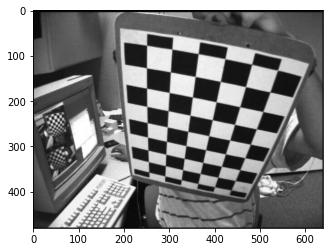

In [154]:
plt.imshow(images_gray[img_idx], cmap='gray')

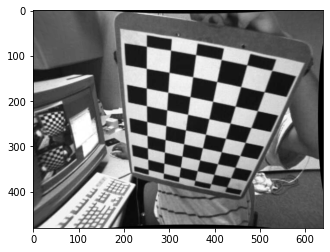

In [155]:
plt.imshow(images_undistorted, cmap='gray')